**Objective:** 

In this tutorial we will create a simple magnetic problem from scratch using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.


In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


C:\Users\dominiquef.MIRAGEOSCIENCE\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [7]:
from SimPEG import *
from simpegPF import BaseMag as MAG


In [16]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = (50000., 90.,0.)

# Assume all induced so the magnetization M is also in the same direction
M = np.array([90,0])

# Create a mesh
hxind = [(5, 20)]
hyind = [(5, 20)]
hzind = [(5, 10)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Assume flat topo for now, so all cells are active
nC   = mesh.nC 
actv = np.asarray(range(mesh.nC))


# Create and array of observation points
xr = np.linspace(-20., 20., 20)
yr = np.linspace(-20., 20., 20)
X, Y = np.meshgrid(xr, yr)
Z = np.ones(X.size)*(mesh.vectorNz[-1]+1.) # Let just put the observation flat

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = MAG.RxObs(rxLoc)
srcField = MAG.SrcField([rxLoc],H0)
survey = MAG.LinearSurvey(srcField) 


Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [17]:
actv[2]

2

In [20]:
# First, convert the magnetization direction to Cartesian
# mi = np.ones(mesh.nC) * M[1]
# md = np.ones(mesh.nC) * M[2]
# M_xyz = PF.Magnetics.dipazm_2_xyz( mi , md ) # Ouputs an nc x 3 array

# We can now create a susceptibility model and generate data
# Lets start with a simple block in half-space
model = np.zeros((mesh.nCx,mesh.nCy,mesh.nCz))
model[8:11,8:11,6:9] = 0.01
model = mkvc(model)

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP = int(mesh.nC))

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, mapping = idenMap, actInd = actv)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
data = prob.fields(model)

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



<IPython.core.display.Javascript object>


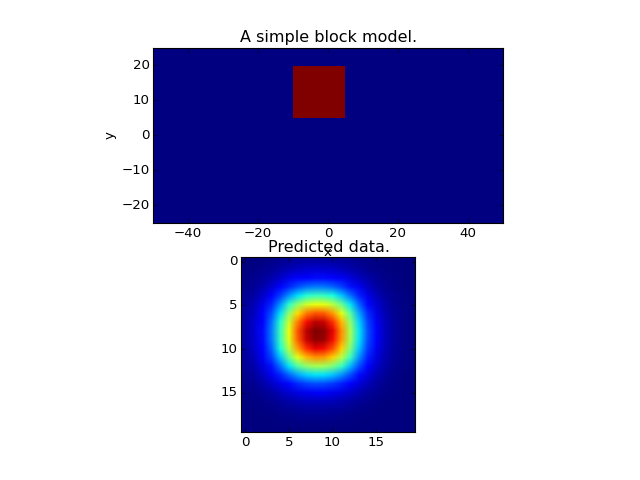

In [21]:

# Create a few models
figure()
ax = subplot(211)
mesh.plotSlice(model, ax = ax, normal = 'Y', ind=10)
title('A simple block model.')
xlabel('x');ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
subplot(212)
imshow(data.reshape(X.shape))
title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')


Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

In [28]:
#survey.makeSyntheticData(data, std=0.01)
survey.dobs=data
survey.std = np.ones(len(data))
survey.mtrue = model

# Create distance weights
wr = np.sum(prob.G**2.,axis=0)**0.5 / mesh.vol[actv]
wr = ( wr/np.max(wr) )

beta_in = 1e+3

reg = Regularization.Simple(mesh, indActive = actv, mapping = idenMap)
reg.wght = wr

diagA = np.sum(prob.G**2.,axis=0) + beta_in*(reg.W.T*reg.W).diagonal()*wr
PC     = Utils.sdiag(diagA**-1.)


dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./survey.std
opt = Optimization.ProjectedGNCG(maxIter=10, lower=0.,upper=1., maxIterCG= 20, tolCG = 1e-3)
opt.approxHinv = PC

# opt = Optimization.InexactGaussNewton(maxIter=6)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta = beta_in)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
#betaest = Directives.BetaEstimate_ByEig()
target = Directives.TargetMisfit()

inv = Inversion.BaseInversion(invProb, directiveList=[beta,target])
m0 = np.ones(mesh.nC)*1e-4
m0 = m0[actv]

# Run inversion
mrec = inv.run(m0)



SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.00e+03  1.24e+05  0.00e+00  1.24e+05    4.44e+01      0              
   1  5.00e+02  4.40e+04  2.90e-02  4.40e+04    3.84e+01      0              
   2  2.50e+02  2.58e+03  4.67e-02  2.60e+03    3.88e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.2393e+04
1 : |xc-x_last| = 8.6767e-02 <= tolX*(1+|x0|) = 1.0063e-01
0 : |proj(x-g)-x|    = 3.8757e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.8757e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10   

<IPython.core.display.Javascript object>


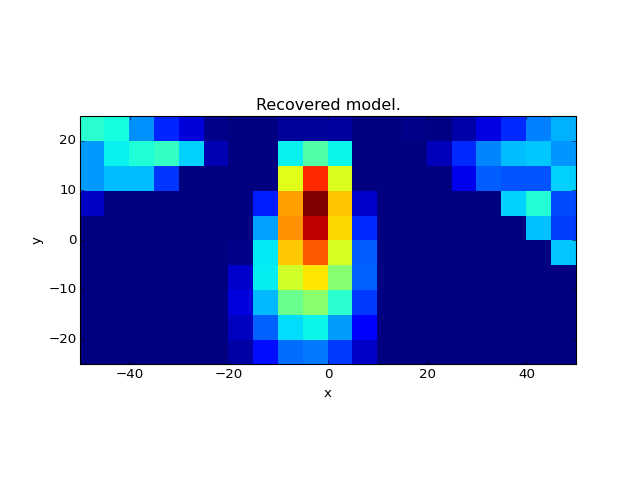

In [29]:
plt.figure()
ax = subplot()
mesh.plotSlice(mrec, ax = ax, normal = 'Y', ind=10)
title('Recovered model.')
xlabel('x');ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

Hopefully you now have an idea of how to create a Problem class in SimPEG, and how this can be used with the other tools available.